In [1]:
cd ~/Desktop/proj_cs109/Data

/Users/Nick/Desktop/proj_cs109/Data


In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import sys
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from numpy.random import randint
from sklearn.metrics import mean_squared_error
import seaborn as sns
import sklearn.metrics as metrics
from sklearn.metrics import r2_score
import scipy.stats
from sklearn.metrics import auc
from sklearn.preprocessing import PolynomialFeatures

In [3]:
#read in imputed data
df_full = pd.read_csv('post_imputation.csv', index_col = 0)

In [4]:
#drop non-cognitive tests/non-gene expression data
df_full = df_full.drop(['SubjectID', 'Phase', 'Visit',
       '260/280', '260/230', 'RIN', 'Affy Plate', 'YearofCollection', 'RID',
       'VISCODE', 'SITE', 'COLPROT', 'ORIGPROT', 'EXAMDATE', 'DX_bl', 'AGE',
       'PTGENDER', 'PTEDUCAT', 'PTETHCAT', 'PTRACCAT', 'PTMARRY',
       'Years_bl', 'Month_bl', 'Month', 'M', 'update_stamp'], axis = 1)

#remove those whose mental state deteriorated or improved
df_full = df_full[df_full['DX_Final_Progression'] == 0]

In [5]:
#define cognitive tests columns
cog_tests = ['ADAS11', 'ADAS13', 'MMSE', 'FAQ', 'MOCA', 'EcogSPMem', 'EcogSPLang',
       'EcogSPVisspat', 'EcogSPPlan', 'EcogSPOrgan', 'EcogSPDivatt',
       'EcogSPTotal', 'DX', 'Final_DX']

In [6]:
#define gene expression data
X_full = df_full.iloc[:,14:49400]

In [7]:
#status checker
def for_loop_status(length, index = 0):
    sys.stdout.write('\r%f%%' % ((index/length)*100))
    sys.stdout.flush()
    index += 1
    return(index)

In [8]:
#load gene expression data into a dataframe
gene_corr_df = pd.DataFrame(columns = df_full.columns[14:49400])

In [9]:
#preallocate arrays for correaltions
gene_corr_base_df = np.empty([49386,1])
gene_corr_cut_df = np.empty([49386,1])
gene_corr_p_df = np.empty([49386,1])

# split into train and test
np.random.seed(9001)
msk = np.random.rand(len(df_full)) < 0.5
df_train = df_full[msk]
df_test = df_full[~msk]

#define train and test set
X_train = df_train.iloc[:,14:49400]
X_test = df_test.iloc[:,14:49400]

#prepare t test
z_l = scipy.stats.t.ppf(0.025, df = 49383)
z_u = scipy.stats.t.ppf(0.975, df = 49383)
                           
#define gene columns
gene_cols = X_full.columns

#get correlation data of each gene with each cognitive test
for cog in cog_tests:
    y_train = df_train[cog]
    y_test = df_test[cog]
    
    # compute correlations of cognitive tests with all genes
    gene_corr_base = []
    gene_corr_cut = []
    gene_corr_p = []
    length = len(gene_cols) - 1
    
    #status check
    print(cog, 1)
    index = 0
    for gene in gene_cols:
        gene_corr_base.append(X_full[gene].corr(df_full[cog]))
        index = for_loop_status(length, index)

    # compute critical values
    mean = np.mean(gene_corr_base)
    std = np.std(gene_corr_base)
    c_l = mean + z_l*std
    c_u = mean + z_u*std
    
    #status check
    print(cog, 2)
    index = 0
    
    #ASK LEAH
    for gene in gene_cols:
        corr = gene_corr_base[index]
        significance = scipy.stats.norm.cdf(-abs(corr)/std)
        gene_corr_base[index] = abs(corr)
        if corr > c_l and corr < c_u:
            corr = 0
        gene_corr_cut.append(abs(corr))
        gene_corr_p.append(significance)
        index = for_loop_status(length, index)

    # store correlation data in dataframe
    gene_corr_base_df = np.column_stack((gene_corr_base_df, gene_corr_base))
    gene_corr_cut_df = np.column_stack((gene_corr_cut_df, gene_corr_cut))
    gene_corr_p_df = np.column_stack((gene_corr_p_df, gene_corr_p))

ADAS11 1
100.000000%ADAS13 1
100.000000%ADAS13 2
100.000000%FAQ 1
100.000000%MOCA 2
100.000000%EcogSPMem 1
100.000000%EcogSPMem 2
100.000000%EcogSPLang 1
100.000000%EcogSPLang 2
100.000000%EcogSPVisspat 2
100.000000%EcogSPPlan 1
100.000000%EcogSPPlan 2
100.000000%EcogSPOrgan 2
100.000000%EcogSPDivatt 2
100.000000%EcogSPTotal 1
100.000000%EcogSPTotal 2
100.000000%DX 1
100.000000%DX 2
100.000000%Final_DX 1
99.763086%

In [10]:
#sum correlations
backup_p = gene_corr_p_df.sum(axis=1)
backup_cut = gene_corr_cut_df.sum(axis=1)
backup_corr = gene_corr_base_df.sum(axis=1)

In [11]:
#export CSVs
np.savetxt("gene_corr_base.csv", backup_corr, delimiter=",")
np.savetxt("gene_corr_cut.csv", backup_cut, delimiter=",")
np.savetxt("gene_corr_p.csv", backup_p, delimiter=",")
np.savetxt("gene_corr_base_raw.csv", gene_corr_base_df, delimiter=",")
np.savetxt("gene_corr_cut_raw.csv", gene_corr_cut_df, delimiter=",")
np.savetxt("gene_corr_p_df_raw.csv", gene_corr_p_df, delimiter=",")

In [12]:
np.savetxt("gene_names.csv", gene_cols, delimiter=",", fmt = '%s')

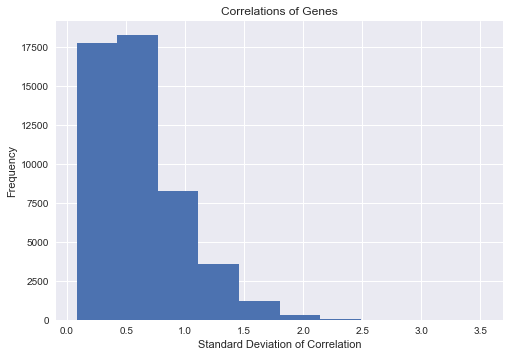

In [13]:
plt.hist(backup_corr)
plt.xlabel('Standard Deviation of Correlation')
plt.ylabel('Frequency')
plt.title('Correlations of Genes')
plt.show()